In [1]:
import requests
import pandas as pd
import io
import pandas as pd
import time
import io
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor


In [2]:
# Read in NYSE data from url
url = "https://raw.githubusercontent.com/ucla-econ-425t/2023winter/master/slides/data/NYSE.csv"
s = requests.get(url).content.decode('utf-8')
NYSE = pd.read_csv(io.StringIO(s), index_col = 0)
NYSE

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True
...,...,...,...,...,...
1986-12-24,wed,0.006514,-0.236104,-9.807366,False
1986-12-26,fri,0.001825,-1.322425,-9.906025,False
1986-12-29,mon,-0.009515,-0.371237,-9.827660,False


In [3]:
L = 5

for s in range(1,L+1):
    NYSE[f'DJ_return_lag{s}']= NYSE['DJ_return'].shift(s)
    NYSE[f'log_volume_lag{s}']= NYSE['log_volume'].shift(s)
    NYSE[f'log_volatility]_lag{s}'] = NYSE['log_volatility'].shift(s)
NYSE = NYSE.reindex(sorted(NYSE.columns),axis = 1)

<Figure size 432x288 with 0 Axes>

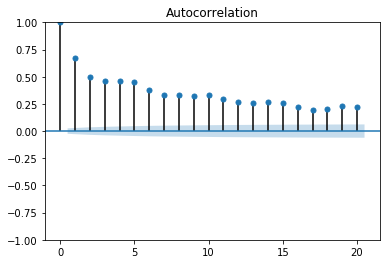

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(NYSE['log_volume'], lags = 20)
plt.show()



<Figure size 432x288 with 0 Axes>

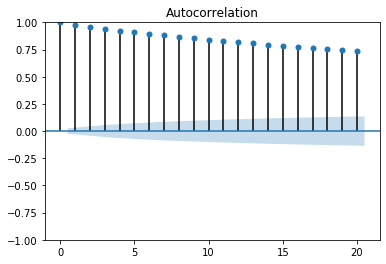

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(NYSE['log_volatility'], lags = 20)
plt.show()


<Figure size 432x288 with 0 Axes>

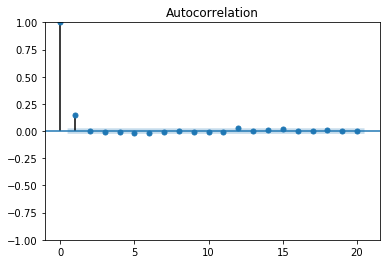

In [6]:
plt.figure()
plot_acf(NYSE['DJ_return'], lags = 20)
plt.show()

In [7]:
NYSE_other = NYSE[NYSE['train']== True].dropna()
NYSE_other.shape

(4276, 20)

In [8]:
NYSE_test = NYSE[NYSE['train']== False]
NYSE_test.shape

(1770, 20)

In [87]:
corr = NYSE.filter(regex = 'log_volume*|DJ_return*|log_volatility*').corr()
corr.style.background_gradient(cmap = 'coolwarm')

,DJ_return,DJ_return_lag1,DJ_return_lag2,DJ_return_lag3,DJ_return_lag4,DJ_return_lag5,log_volatility,log_volatility]_lag1,log_volatility]_lag2,log_volatility]_lag3,log_volatility]_lag4,log_volatility]_lag5,log_volume,log_volume_lag1,log_volume_lag2,log_volume_lag3,log_volume_lag4,log_volume_lag5
DJ_return,1.000000,0.143388,-0.003597,-0.005304,-0.005528,-0.014239,0.026793,0.014177,0.013557,0.010581,0.008297,0.009971,0.200892,0.047600,0.015934,0.008729,-0.004202,0.002981
DJ_return_lag1,0.143388,1.000000,0.143365,-0.003752,-0.005278,-0.005428,0.021996,0.026778,0.014163,0.013561,0.010570,0.008303,0.211669,0.200776,0.047396,0.015730,0.007997,-0.004333
DJ_return_lag2,-0.003597,0.143365,1.000000,0.143336,-0.003744,-0.005249,0.017013,0.021991,0.026773,0.014164,0.013557,0.010572,0.108032,0.211648,0.200756,0.047345,0.015549,0.007959
DJ_return_lag3,-0.005304,-0.003752,0.143336,1.000000,0.143389,-0.003602,0.011547,0.016992,0.021972,0.026780,0.014149,0.013568,0.110325,0.107846,0.211410,0.200523,0.046402,0.015366
DJ_return_lag4,-0.005528,-0.005278,-0.003744,0.143389,1.000000,0.143372,0.000350,0.011551,0.016995,0.021972,0.026783,0.014148,0.090132,0.110372,0.107921,0.211503,0.201233,0.046438
DJ_return_lag5,-0.014239,-0.005428,-0.005249,-0.003602,0.143372,1.000000,-0.006393,0.000366,0.011565,0.016994,0.021983,0.026778,0.070240,0.090282,0.110601,0.108141,0.212769,0.201379
log_volatility,0.026793,0.021996,0.017013,0.011547,0.000350,-0.006393,1.000000,0.980054,0.960890,0.943046,0.926665,0.910997,0.046306,0.036211,0.027911,0.021485,0.015350,0.003120
log_volatility]_lag1,0.014177,0.026778,0.021991,0.016992,0.011551,0.000366,0.980054,1.000000,0.980054,0.960892,0.943046,0.926668,0.010394,0.046288,0.036186,0.027885,0.021425,0.015331
log_volatility]_lag2,0.013557,0.014163,0.026773,0.021972,0.016995,0.011565,0.960890,0.980054,1.000000,0.980056,0.960892,0.943049,-0.029914,0.010375,0.046269,0.036164,0.027853,0.021409
log_volatility]_lag3,0.010581,0.013561,0.014164,0.026780,0.021972,0.016994,0.943046,0.960892,0.980056,1.000000,0.980056,0.960892,-0.034688,-0.029913,0.010383,0.046283,0.036277,0.027859


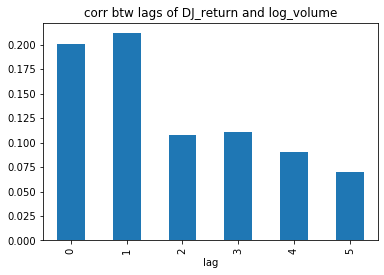

In [88]:
plt.figure()
corr['log_volume'].filter(regex = 'DJ_return*').plot(
    x = range(1, L + 1),
    kind = 'bar',
    use_index = False
    ).set_xlabel('lag')
plt.title('corr btw lags of DJ_return and log_volume')
plt.show()

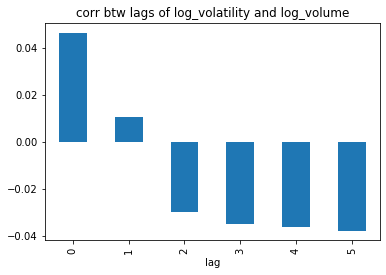

In [89]:
plt.figure()
corr['log_volume'].filter(regex = 'log_volatility*').plot(
    x = range(1, L + 1),
    kind = 'bar',
    use_index = False
    ).set_xlabel('lag')
plt.title('corr btw lags of log_volatility and log_volume')
plt.show()

In [9]:
include_dow = False
if include_dow:
    X_other = NYSE_other.drop(['train','DJ_return','log_volume','log_volatility'],axis =1)
    y_other = NYSE_other['log_volume']

    X_test = NYSE_test.drop(['train','DJ_return','log_volume','log_volatility'],axis =1)
    y_test = NYSE_test['log_volume']
else:
    X_other = NYSE_other.drop(['train','DJ_return','log_volume','log_volatility','day_of_week'],axis =1)
    y_other = NYSE_other['log_volume']
    
    X_test = NYSE_test.drop(['train','DJ_return','log_volume','log_volatility','day_of_week'],axis =1)
    y_test = NYSE_test['log_volume']
    
print('Train set shape:',X_other.shape,y_other.shape)
print('Test set shape:',X_test.shape,y_test.shape)

Train set shape: (4276, 15) (4276,)
Test set shape: (1770, 15) (1770,)


In [10]:
r2_train_strawman = r2_score(y_other,X_other['log_volume_lag1'])
print('Straw man train R2: ', r2_train_strawman)

Straw man train R2:  0.4199386914132621


In [11]:
r2_test_strawman = r2_score(y_test,X_test['log_volume_lag1'])
print('Straw man test R2: ', r2_test_strawman)

Straw man test R2:  0.18026287838158628


In [61]:
cat_features = X_other.select_dtypes(exclude = 'float64').columns
num_features = X_other.select_dtypes('float64').columns

cat_tf = Pipeline(steps = [('encoder',OneHotEncoder(drop = 'first'))])

num_tf = Pipeline(steps = [('std',StandardScaler())])
col_tf = ColumnTransformer(transformers = [('num',num_tf,num_features),('cat',cat_tf,cat_features)])

col_tf

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std', StandardScaler())]),
                                 Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility]_lag1', 'log_volatility]_lag2',
       'log_volatility]_lag3', 'log_volatility]_lag4', 'log_volatility]_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 Index([], dtype='object'))])

In [13]:
# elestic net model

In [14]:
enet_mod = ElasticNet(
    alpha = 1.0,
    l1_ratio = 0.5, 
    max_iter = 10000, 
    warm_start = True, 
    random_state = 425)
enet_mod

ElasticNet(max_iter=10000, random_state=425, warm_start=True)

In [15]:
enet_pipe = Pipeline(steps = [('col_tf',enet_col_tf),('model',enet_mod)])
enet_pipe

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  Index(['DJ_return_lag1', 'DJ_return_lag2', 'DJ_return_lag3', 'DJ_return_lag4',
       'DJ_return_lag5', 'log_volatility]_lag1', 'log_volatility]_lag2',
       'log_volatility]_lag3', 'log_volatility]_lag4', 'log_volatility]_lag5',
       'log_volume_lag1', 'log_volume_lag2', 'log_volume_lag3',
       'log_volume_lag4', 'log_volume_lag5'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index([], dtype='object'))])),
                ('model'

In [16]:
alpha_grid = np.logspace(start = -12, stop = 2, num =10)
l1_ratio_grid = [0.0,0.2,0.4,0.6,0.8,1.0]
enet_tuned_parameters = {'model__alpha':alpha_grid, 'model__l1_ratio':l1_ratio_grid}
enet_tuned_parameters

{'model__alpha': array([1.00000000e-12, 3.59381366e-11, 1.29154967e-09, 4.64158883e-08,
        1.66810054e-06, 5.99484250e-05, 2.15443469e-03, 7.74263683e-02,
        2.78255940e+00, 1.00000000e+02]),
 'model__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}

In [17]:
enet_search = GridSearchCV(
  enet_pipe, 
  enet_tuned_parameters, 
  cv = TimeSeriesSplit(5),
    scoring = 'r2',
  # Refit the best model on the whole data set
  refit = True 
  )

In [18]:
tic = time.time()
enet_search.fit(X_other,y_other)
toc = time.time()
print('Execution time: ',toc -tic,'seconds')

/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.786e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.786e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.810e+00, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+01, tolerance: 2.662e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.960e+01, tolerance: 6.028e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

Execution time:  14.659173011779785 seconds


/Users/kimberly/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.890e+01, tolerance: 2.278e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [82]:
r2_cv_enet = enet_search.best_score_
r2_cv_enet

0.5562909699696534

In [20]:
r2_train_enet = r2_score(y_other,enet_search.best_estimator_.predict(X_other))
r2_train_enet

0.5707150392146101

### THE CV R^2 is 0.55629, and the training R^2 is 0.570715

In [21]:
r2_test_enet = r2_score(y_test,enet_search.best_estimator_.predict(X_test))
r2_test_enet

0.41289129385640577

### MLP

In [22]:
from sklearn.neural_network import MLPRegressor

mlp_mod = MLPRegressor(
  hidden_layer_sizes = (8, 4),
  activation = 'relu',
  solver = 'adam',
  batch_size = 16,
  random_state = 425
  )

In [23]:
from sklearn.pipeline import Pipeline

mlp_pipe = Pipeline(steps = [
  ("model", mlp_mod)
  ])
mlp_pipe

Pipeline(steps=[('model',
                 MLPRegressor(batch_size=16, hidden_layer_sizes=(8, 4),
                              random_state=425))])

In [24]:
# Tune hyper-parameter(s)
hls_grid = [(4), (8), (12), (4, 2), (8, 4), (12, 6)] # hidden layer size
bs_grid = [4, 8, 12, 16, 20, 24, 28, 32] # batch sizes
mlp_tuned_parameters = {
  "model__hidden_layer_sizes": hls_grid,
  "model__batch_size": bs_grid
  }
mlp_tuned_parameters 

{'model__hidden_layer_sizes': [4, 8, 12, (4, 2), (8, 4), (12, 6)],
 'model__batch_size': [4, 8, 12, 16, 20, 24, 28, 32]}

In [25]:
from sklearn.model_selection import GridSearchCV

# Set up CV
mlp_search = GridSearchCV(
  mlp_pipe, 
  mlp_tuned_parameters, 
  cv = TimeSeriesSplit(5), 
  scoring = "r2",
  error_score = 'raise',
  # Refit the best model on the whole data set
  refit = True 
  )

In [26]:
# Fit CV
mlp_search.fit(X_other, y_other)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('model',
                                        MLPRegressor(batch_size=16,
                                                     hidden_layer_sizes=(8, 4),
                                                     random_state=425))]),
             param_grid={'model__batch_size': [4, 8, 12, 16, 20, 24, 28, 32],
                         'model__hidden_layer_sizes': [4, 8, 12, (4, 2), (8, 4),
                                                       (12, 6)]},
             scoring='r2')

In [27]:
r2_cv_mlp = mlp_search.best_score_
r2_cv_mlp

0.5298718970687661

In [28]:
r2_train_mlp = r2_score(y_other,mlp_search.best_estimator_.predict(X_other))
r2_train_mlp

0.5358351758182354

In [29]:
r2_test_mlp = r2_score(
    y_test,
    mlp_search.best_estimator_.predict(X_test)
)
r2_test_mlp

0.3715929437370552

In [30]:
!pip install tensorflow

In [31]:
import tensorflow

2023-03-18 18:44:55.325130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
from tensorflow import keras

## 6 LSTM

In [33]:
train_val_split_fraction = 0.8
train_split = int(train_val_split_fraction * int(X_other.shape[0]))
if include_dow:
    predictors = ['log_volatility','DJ_return','log_volume','day_of_week']
else:
    predictors = ['log_volatility','DJ_return','log_volume']
batch_size = 4
learning_rate = 0.001
epochs = 20
sequence_length = 5

#train
train_data = NYSE[predictors].iloc[0:train_split - L -1]
X_train = train_data[[i for i in predictors]].values
y_train = NYSE['log_volume'].iloc[L:train_split]
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
X_train,
y_train,
sequence_length = sequence_length,
sampling_rate =1,
batch_size = batch_size,
shuffle = False)

2023-03-18 18:45:03.574679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
for batch in dataset_train.take(1):
    inputs,targets = batch
print('Input shape: ', inputs.numpy().shape)
print('Target shape: ', targets.numpy().shape)

Input shape:  (4, 5, 3)
Target shape:  (4,)


In [35]:
# validation

In [36]:
val_data = NYSE[predictors].iloc[(train_split - L):(X_other.shape[0]-2)]
X_val = val_data[[i for i in predictors]].values
y_val = NYSE['log_volume'].iloc[train_split:(X_other.shape[0]+L-2)]
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
X_val,
y_val,
sequence_length = sequence_length,
sampling_rate =1,
batch_size = batch_size,)

In [37]:
inputs = keras.layers.Input(shape = (inputs.shape[1],inputs.shape[2]))
lstm_out = keras.layers.LSTM(12)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs = inputs,
                   outputs = outputs)
model.compile(
optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
loss = 'mse',
metrics =[tensorflow.keras.metrics.CosineSimilarity(axis =1)])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 12)                768       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________


In [38]:
# train

In [39]:
history = model.fit(dataset_train,
                   epochs = epochs,
                   validation_data = dataset_val,
                   verbose =2 )

Epoch 1/20
853/853 - 4s - loss: 0.0508 - cosine_similarity: 0.1836 - val_loss: 0.0398 - val_cosine_similarity: 0.2117 - 4s/epoch - 5ms/step
Epoch 2/20
853/853 - 2s - loss: 0.0288 - cosine_similarity: 0.5443 - val_loss: 0.0342 - val_cosine_similarity: 0.3942 - 2s/epoch - 2ms/step
Epoch 3/20
853/853 - 2s - loss: 0.0264 - cosine_similarity: 0.5683 - val_loss: 0.0339 - val_cosine_similarity: 0.4082 - 2s/epoch - 2ms/step
Epoch 4/20
853/853 - 2s - loss: 0.0261 - cosine_similarity: 0.5730 - val_loss: 0.0336 - val_cosine_similarity: 0.4082 - 2s/epoch - 2ms/step
Epoch 5/20
853/853 - 2s - loss: 0.0260 - cosine_similarity: 0.5742 - val_loss: 0.0326 - val_cosine_similarity: 0.4222 - 2s/epoch - 2ms/step
Epoch 6/20
853/853 - 2s - loss: 0.0259 - cosine_similarity: 0.5754 - val_loss: 0.0316 - val_cosine_similarity: 0.4409 - 2s/epoch - 2ms/step
Epoch 7/20
853/853 - 2s - loss: 0.0258 - cosine_similarity: 0.5771 - val_loss: 0.0306 - val_cosine_similarity: 0.4667 - 2s/epoch - 2ms/step
Epoch 8/20
853/853 -

In [40]:
# final test performance 

In [41]:
# test
test_data = NYSE[predictors].iloc[NYSE_other.shape[0]:]
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
test_data[[i for i in predictors]].values,
y_test,
sequence_length = sequence_length,
sampling_rate =1 ,
batch_size = batch_size,)

In [42]:
NYSE[predictors].iloc[NYSE_other.shape[0]:(NYSE_other.shape[0] + 7)]

,log_volatility,DJ_return,log_volume
date,,,
1979-12-24,-10.385307,0.000298,-0.631830
1979-12-26,-10.485360,-0.001216,-0.365829
1979-12-27,-10.569258,0.002336,-0.137014
1979-12-28,-10.665966,-0.001418,-0.041932
1979-12-31,-10.771131,-0.000203,-0.125945
1980-01-02,-9.945787,-0.017039,0.117599
1980-01-03,-9.990808,-0.005180,0.331630


In [43]:
score,cossim = model.evaluate(dataset_test,
                             batch_size = batch_size,
                             verbose = 2)
print('Test score: ', score)
print('Test metric: ',cossim)

443/443 - 1s - loss: 0.0377 - cosine_similarity: 0.4508 - 573ms/epoch - 1ms/step
Test score:  0.03772404044866562
Test metric:  0.45084744691848755


In [44]:
r2_test_lstm = r2_score(y_test,
                       np.c_[model.predict(
                       dataset_test,
                       batch_size = batch_size,
                       verbose = 2)].flatten())
r2_test_lstm
                    

443/443 - 1s - 810ms/epoch - 2ms/step


0.3442790302647364

## 7 Random forest  

In [45]:
from sklearn.ensemble import RandomForestRegressor
rf_mod = RandomForestRegressor(
# Number of trees
n_estimators = 100,
criterion = 'squared_error',
# Number of features to use in each split max_features = 'sqrt',
oob_score = True, random_state = 425 )

In [46]:
from sklearn.pipeline import Pipeline
rf_pipe = Pipeline(steps = [ ("model", rf_mod)
])
rf_pipe

Pipeline(steps=[('model',
                 RandomForestRegressor(oob_score=True, random_state=425))])

In [47]:
# Tune hyper-parameter(s)
B_grid = [50, 100, 150, 200, 250, 300]
m_grid = ['sqrt', 'log2', 1.0] # max_features = 1.0 uses all features
rf_tuned_parameters = {
  "model__n_estimators": B_grid,
  "model__max_features": m_grid
  }
rf_tuned_parameters  

{'model__n_estimators': [50, 100, 150, 200, 250, 300],
 'model__max_features': ['sqrt', 'log2', 1.0]}

In [48]:
from sklearn.model_selection import GridSearchCV

# Set up CV
n_folds = 6
rf_search = GridSearchCV(
  rf_pipe,
  rf_tuned_parameters,
  cv = TimeSeriesSplit(5), 
  scoring = "r2",
  # Refit the best model on the whole data set
  refit = True
  )

In [49]:
# Fit CV
rf_search.fit(X_other, y_other)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        RandomForestRegressor(oob_score=True,
                                                              random_state=425))]),
             param_grid={'model__max_features': ['sqrt', 'log2', 1.0],
                         'model__n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='r2')

In [50]:
r2_cv_rf = rf_search.best_score_
r2_cv_rf

0.5345647332187802

In [51]:
rf_search.best_estimator_

Pipeline(steps=[('model',
                 RandomForestRegressor(max_features=1.0, n_estimators=300,
                                       oob_score=True, random_state=425))])

In [52]:
r2_train_rf = r2_score(
    y_other,
    rf_search.best_estimator_.predict(X_other)
)
print('RF train R2:',r2_train_rf)

RF train R2: 0.9407256020188164


In [53]:
r2_test_rf = r2_score(
    y_test,
    rf_search.best_estimator_.predict(X_test)
)
print('RF test R2:',r2_test_rf)

RF test R2: 0.4003886528302093


## 8 boosting 

In [54]:
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.tree import DecisionTreeRegressor
bst_mod = AdaBoostRegressor(
# Default base estimator is DecisionTreeRegressor with max_depth = 3 base_estimator = DecisionTreeRegressor(max_depth = 3),
base_estimator = DecisionTreeRegressor(max_depth = 3),
# Number of trees (to be tuned)
n_estimators = 50,
# Learning rate (to be tuned)
learning_rate = 1.0,
random_state = 425
)

In [78]:
from sklearn.pipeline import Pipeline

bst_pipe = Pipeline(steps = [
  ("model", bst_mod)
  ])
bst_pipe

Pipeline(steps=[('model',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                                   random_state=425))])

In [66]:
# Tune hyper-parameter(s)
d_grid = [
  DecisionTreeRegressor(max_depth = 1),
  DecisionTreeRegressor(max_depth = 2),
  DecisionTreeRegressor(max_depth = 3),
  DecisionTreeRegressor(max_depth = 4)
  ]
B_grid = [50, 100, 150, 200, 250, 300, 350, 400]
lambda_grid = [0.2, 0.4, 0.6, 0.8, 1.0]
bst_tuned_parameters = {
  "model__base_estimator": d_grid,
  "model__n_estimators": B_grid,
  "model__learning_rate": lambda_grid
  }
bst_tuned_parameters  

{'model__base_estimator': [DecisionTreeRegressor(max_depth=1),
  DecisionTreeRegressor(max_depth=2),
  DecisionTreeRegressor(max_depth=3),
  DecisionTreeRegressor(max_depth=4)],
 'model__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
 'model__learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0]}

In [67]:
from sklearn.model_selection import GridSearchCV

# Set up CV
bst_search = GridSearchCV(
  bst_pipe,
  bst_tuned_parameters,
  cv = TimeSeriesSplit(5),  
  scoring = "r2",
  # Refit the best model on the whole data set
  refit = True
  )

In [68]:
# Fit CV
bst_search.fit(X_other, y_other)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                                                          random_state=425))]),
             param_grid={'model__base_estimator': [DecisionTreeRegressor(max_depth=1),
                                                   DecisionTreeRegressor(max_depth=2),
                                                   DecisionTreeRegressor(max_depth=3),
                                                   DecisionTreeRegressor(max_depth=4)],
                         'model__learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'model__n_estimators': [50, 100, 150, 200, 250, 300,
                                                 350, 400]},
             scoring='r2')

In [70]:
r2_cv_bst = bst_search.best_score_
r2_cv_bst

0.5189909701218139

In [72]:
bst_search.best_estimator_

Pipeline(steps=[('model',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                                   learning_rate=0.2, n_estimators=100,
                                   random_state=425))])

In [74]:
r2_train_bst = r2_score(
    y_other,
    bst_search.best_estimator_.predict(X_other)
)
print('Boosting train R2:',r2_train_bst)

Boosting train R2: 0.5932792973500349


In [76]:
r2_test_bst = r2_score(
    y_test,
    bst_search.best_estimator_.predict(X_test)
)
print('Boosting test R2:',r2_test_bst)

Boosting test R2: 0.36095350451672636


In [85]:
summary = pd.DataFrame({
    'Baseline': [r2_train_strawman, r2_test_strawman],
    'AR(5)': [r2_cv_enet, r2_test_enet],
    'AR(5)MLP': [r2_cv_mlp,r2_test_mlp], 
    'LSTM': [ '0', r2_test_lstm],
    'Random Forest': [r2_cv_rf, r2_test_rf],
    'Boosting': [r2_cv_bst, r2_test_bst]
})
summary = summary.transpose()
summary = summary.rename(columns={0: 'CV R2', 1: 'Test R2'})
summary

,CV R2,Test R2
Baseline,0.419939,0.180263
AR(5),0.556291,0.412891
AR(5)MLP,0.529872,0.371593
LSTM,0,0.344279
Random Forest,0.534565,0.400389
Boosting,0.518991,0.360954
